In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
from merge_datasets import MergeDatasets
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor

import numpy as np
import os
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# define multi-layer perceptron deep neural network model
# network includes two linear layers, one Relu layer, and one dropout layer
class MLP(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()

        self.linear1 = nn.Linear(input_d, hidden_d)
        self.linear2 = nn.Linear(hidden_d, output_d)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

In [3]:
co2_df = pd.read_csv('../datasets/co2-long-term-concentration.csv')
forest_df = pd.read_csv('../datasets/forest-area-km.csv')
land_df = pd.read_csv('../datasets/land-use-over-the-long-term.csv')
temp_df = pd.read_csv('../datasets/annual-temperature-anomalies.csv')
invas_df = pd.read_csv('../datasets/budget-to-manage-invasive-alien-species.csv')
lpi_df = pd.read_csv('../datasets/global-living-planet-index.csv') # target

merge_datasets = MergeDatasets(co2_df, forest_df, land_df, temp_df, lpi_df)
merged_df = merge_datasets.merge()

features = ['Year', 'Entity', 'Long-run CO₂ concentration', 'Forest area', 'Land use: Built-up area', 
            'Land use: Grazingland', 'Land use: Cropland', 'Temperature anomaly']

entities = pd.get_dummies(merged_df['Entity'])
X_continuous = merged_df[['Year', 'Long-run CO₂ concentration', 'Forest area', 'Land use: Built-up area', 
                          'Land use: Grazingland', 'Land use: Cropland', 'Temperature anomaly']].values
X = np.hstack((X_continuous, entities.values))
print(entities.columns.tolist())

y = merged_df['Living Planet Index'].values.reshape(-1, 1)

/Users/jackzhang/anaconda3/envs/cs4262/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/Users/jackzhang/anaconda3/envs/cs4262/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


['Africa', 'Asia and Pacific', 'Europe and Central Asia', 'Latin America and the Caribbean', 'North America', 'World']


In [5]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale labels
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()  # Flatten to 1D array after scaling

# Convert scaled features and labels to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

input_d = X.shape[1]
hidden_d = 64
output_d = 1

model = MLP(input_d, hidden_d, output_d)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=10,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            output = model(data)

            # Loss function
            loss = criterion(output, target)

            # Backward path (backpropagation)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            # _, pred = torch.max(output, dim=1)
            # correct_tensor = pred.eq(target.data.view_as(pred))

            # # Need to convert correct tensor from int to float to average
            # accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # # Multiply average accuracy times the number of examples in batch
            # train_acc += accuracy.item() * data.size(0)

            # # Track training progress
            # print(
            #     f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            #     end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    # data, target = data.cuda(), target.cuda()

                    # Forward path
                    output = model(data)

                    # Validation loss computation
                    loss = criterion(output, target)

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history, columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss'])
    return model, history

In [34]:
def cross_validate(model_constructor, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=32)

        model = model_constructor()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model, history = train(model, criterion, optimizer, train_loader, val_loader, "model_fold.pth", max_epochs_stop=10, n_epochs=50, print_every=1)

        fold_results.append(history)

    return fold_results

def create_model():
    return MLP(input_d, hidden_d, output_d)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

# Initialize the model
input_d = X.shape[1]  # Adjust the input dimension to match feature number
hidden_d = 64  # Hidden dimension, can be tuned
output_d = 1   # Since it's regression, the output dimension is 1

model = MLP(input_d, hidden_d, output_d)
criterion = nn.MSELoss()  # MSE is typically used for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the file name to save the model
save_file_name = 'best_model.pt'

# Train the model
trained_model, history = train(model=model,
                               criterion=criterion,
                               optimizer=optimizer,
                               train_loader=train_loader,
                               valid_loader=valid_loader,
                               save_file_name=save_file_name,
                               max_epochs_stop=3,
                               n_epochs=50,
                               print_every=1)

# Compute the MSE
# This will be computed as part of the training function in your current setup, printed out, and saved in 'history'
print(f"Final Training MSE: {history['train_loss'].iloc[-1]}")
print(f"Final Validation MSE: {history['valid_loss'].iloc[-1]}")

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0523 	Validation Loss: 0.6419

Epoch: 1 	Training Loss: 0.9420 	Validation Loss: 0.5991

Epoch: 2 	Training Loss: 0.8816 	Validation Loss: 0.5590

Epoch: 3 	Training Loss: 0.7791 	Validation Loss: 0.5199

Epoch: 4 	Training Loss: 0.7747 	Validation Loss: 0.4821

Epoch: 5 	Training Loss: 0.6439 	Validation Loss: 0.4467

Epoch: 6 	Training Loss: 0.6505 	Validation Loss: 0.4068

Epoch: 7 	Training Loss: 0.6058 	Validation Loss: 0.3707

Epoch: 8 	Training Loss: 0.6005 	Validation Loss: 0.3364

Epoch: 9 	Training Loss: 0.5360 	Validation Loss: 0.3036

Epoch: 10 	Training Loss: 0.4633 	Validation Loss: 0.2719

Epoch: 11 	Training Loss: 0.4443 	Validation Loss: 0.2390

Epoch: 12 	Training Loss: 0.3988 	Validation Loss: 0.2058

Epoch: 13 	Training Loss: 0.3159 	Validation Loss: 0.1779

Epoch: 14 	Training Loss: 0.4286 	Validation Loss: 0.1492

Epoch: 15 	Training Loss: 0.3035 	Validation Loss: 0.1259

Epoch: 16 	Training Loss: 0.2732

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

['scaler_X.bin']

['scaler_y.bin']

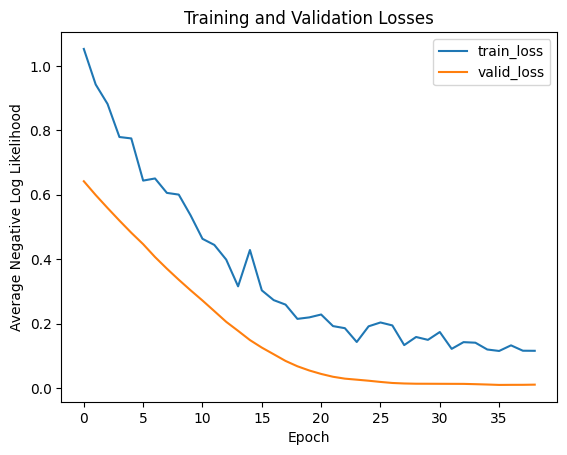

In [36]:
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

torch.save(model.state_dict(), 'model_state.pth')
dump(scaler_X, 'scaler_X.bin')
dump(scaler_y, 'scaler_y.bin')

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.1180 	Validation Loss: 0.5741

Epoch: 1 	Training Loss: 0.9955 	Validation Loss: 0.5165

Epoch: 2 	Training Loss: 0.8593 	Validation Loss: 0.4658

Epoch: 3 	Training Loss: 0.8445 	Validation Loss: 0.4163

Epoch: 4 	Training Loss: 0.7117 	Validation Loss: 0.3698

Epoch: 5 	Training Loss: 0.6340 	Validation Loss: 0.3269

Epoch: 6 	Training Loss: 0.5982 	Validation Loss: 0.2832

Epoch: 7 	Training Loss: 0.5056 	Validation Loss: 0.2425

Epoch: 8 	Training Loss: 0.4491 	Validation Loss: 0.2069

Epoch: 9 	Training Loss: 0.3959 	Validation Loss: 0.1745

Epoch: 10 	Training Loss: 0.3827 	Validation Loss: 0.1444

Epoch: 11 	Training Loss: 0.3196 	Validation Loss: 0.1176

Epoch: 12 	Training Loss: 0.2645 	Validation Loss: 0.0948

Epoch: 13 	Training Loss: 0.2563 	Validation Loss: 0.0763

Epoch: 14 	Training Loss: 0.2526 	Validation Loss: 0.0636

Epoch: 15 	Training Loss: 0.2127 	Validation Loss: 0.0533

Epoch: 16 	Training Loss: 0.2348

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Average Learning Curve Across 5 Folds')

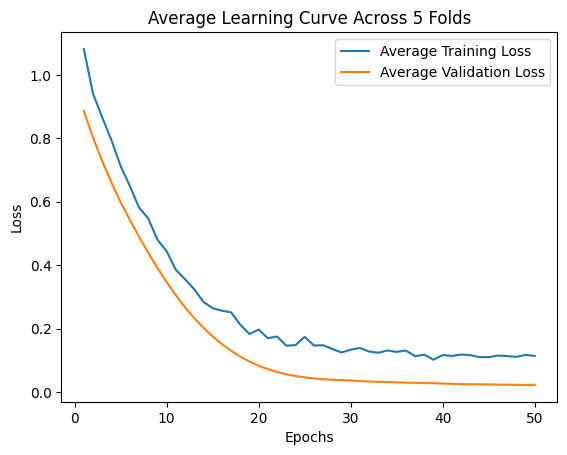

In [37]:
# final evaluation technique
# k-fold cross validation with k=5
fold_results = cross_validate(create_model, X_scaled, y_scaled, n_splits=5)

avg_train_losses = []
avg_valid_losses = []

# Determine the number of epochs based on the first fold's history
num_epochs = len(fold_results[0]['train_loss'])

# Aggregate losses over epochs
for epoch in range(num_epochs):
    epoch_train_losses = [fold['train_loss'][epoch] for fold in fold_results]
    epoch_valid_losses = [fold['valid_loss'][epoch] for fold in fold_results]
    
    # Compute average losses for this epoch
    avg_train_losses.append(np.mean(epoch_train_losses))
    avg_valid_losses.append(np.mean(epoch_valid_losses))

epochs = range(1, num_epochs + 1)
plt.plot(epochs, avg_train_losses, label='Average Training Loss')
plt.plot(epochs, avg_valid_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Learning Curve Across 5 Folds')
plt.legend()
plt.show()

In [38]:
final_valid_losses = [fold['valid_loss'][0] for fold in fold_results]
for i, loss in enumerate(final_valid_losses, 1):
    print(f'Fold {i}: Final Validation Loss: {loss}')

Fold 1: Final Validation Loss: 0.5741232224873134
Fold 2: Final Validation Loss: 0.9149901633816105
Fold 3: Final Validation Loss: 0.9775341033935547
Fold 4: Final Validation Loss: 0.6969966467689065
Fold 5: Final Validation Loss: 1.2685571979073917
